In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


### Loading Data
#CMU Movie Summary Corpus 
#movie.metadata.tsv: Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. The movie genre tags are available in this file
#plot_summaries.txt: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.

In [2]:
file_path = "movie.metadata.tsv"
meta = pd.read_csv(file_path, sep = '\t', header = None)

In [3]:
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### Adding Headers

In [4]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

Load the **movie plot dataset** into memory from plot summaries.txt

In [5]:
file_path_2 = "plot_summaries.txt"
plots = []

with open(file_path_2, 'r', encoding="cp437", errors='ignore') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:05, 7862.89it/s] 


In [6]:
movie_id = []
plot = []

for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

100%|████████████████████████████████████████████████████████████████████████| 42303/42303 [00:00<00:00, 221428.07it/s]


In [7]:
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

In [8]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### Data Exploration and Pre-processing

In [9]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

In [10]:
movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [11]:
movies['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

Converting string to dictionary

In [12]:
type(json.loads(movies['genre'][0]))

dict

In [13]:
json.loads(movies['genre'][0]).values()

dict_values(['Drama', 'World cinema'])

Extract all the genres from the movies data

In [14]:
genres = []

for i in movies['genre']:
  genres.append(list(json.loads(i).values()))
    
movies['genre_new'] = genres

Exclude samples with no Genre tags

In [15]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [16]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

In [17]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


In [18]:
# get all genre tags in a list
all_genres = sum(genres,[])
print(all_genres)
len(set(all_genres))

['Drama', 'World cinema', 'Action/Adventure', 'Science Fiction', 'Action', 'Drama', 'Musical', 'Action', 'Drama', 'Bollywood', 'Screwball comedy', 'Comedy', 'Crime Fiction', 'Drama', 'Docudrama', 'World cinema', 'Courtroom Drama', 'Thriller', 'Action/Adventure', 'Action', 'Drama', 'Thriller', 'Drama', 'Horror', 'Drama', 'Teen', 'Romantic comedy', 'Media Satire', 'Americana', 'Comedy-drama', 'Black-and-white', 'Drama', 'Comedy', 'Romance Film', 'Short Film', 'Family Film', 'Animation', 'Comedy', 'Crime Fiction', 'Drama', 'Comedy', 'World cinema', 'Parody', 'Comedy', 'War film', 'Epic', 'Action/Adventure', 'Period piece', 'Drama', 'Film adaptation', 'Action', 'Political drama', 'Cult', 'Coming of age', 'Comedy', 'Teen', 'Horror', 'Thriller', 'Mystery', 'Comedy film', 'Crime Fiction', 'Horror', 'Drama', 'Thriller', 'Crime Fiction', 'Indie', 'Martial Arts Film', 'Romance Film', 'Action', 'Period piece', 'Drama', 'Indie', 'Drama', 'War film', 'Computer Animation', 'Short Film', 'Family Film

363

Use **FreqDist( )** of the nltk library to create a dictionary of genres and their occurence count across the dataset.

In [19]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

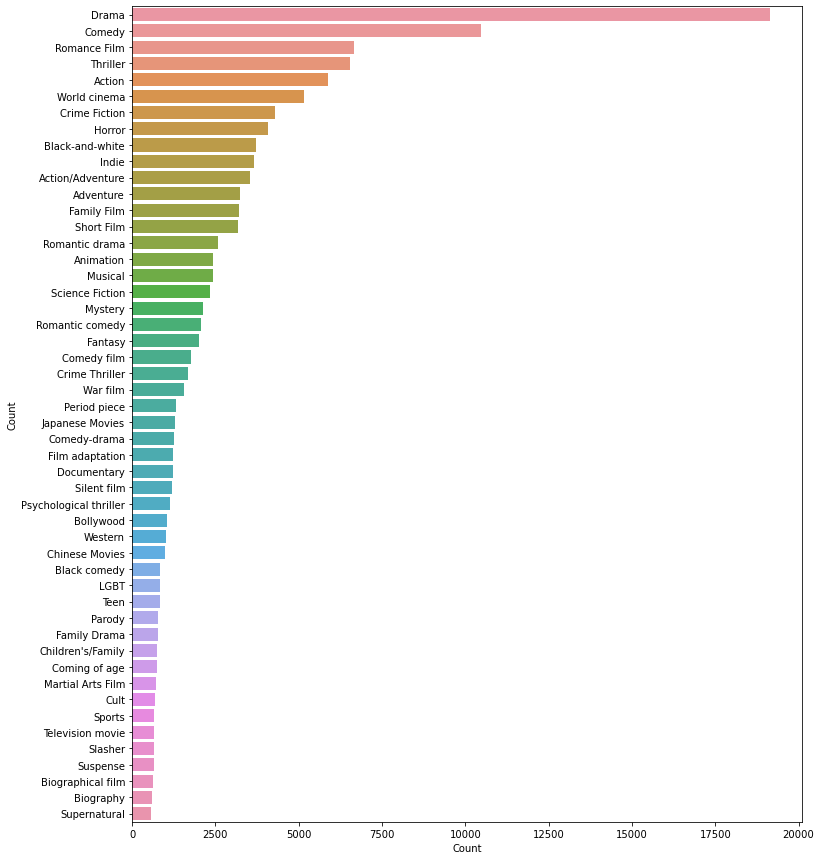

In [20]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

"Drama", "Comedy", "Romance", "Thriller", and "Action" are the most Frequent

In [21]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    
    return text

Applying the cleaning function on the movie plots

In [22]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

<ipython-input-22-cba7721b10bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))


Comparison of new vs old movie plots after cleaning

In [23]:
movies_new[['plot', 'clean_plot']].sample(3)

,plot,clean_plot
37856,ΓÇÿRamboΓÇÖ is a film that surrounds around a ...,rambo is a film that surrounds around a tricks...
36184,"Sinbad , sailor and Prince of Baghdad, seeks p...",sinbad sailor and prince of baghdad seeks perm...
25943,A woman and man who met at a wedding reception...,a woman and man who met at a wedding reception...


Most frequent words in the movie plots (clean_plot).

In [24]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

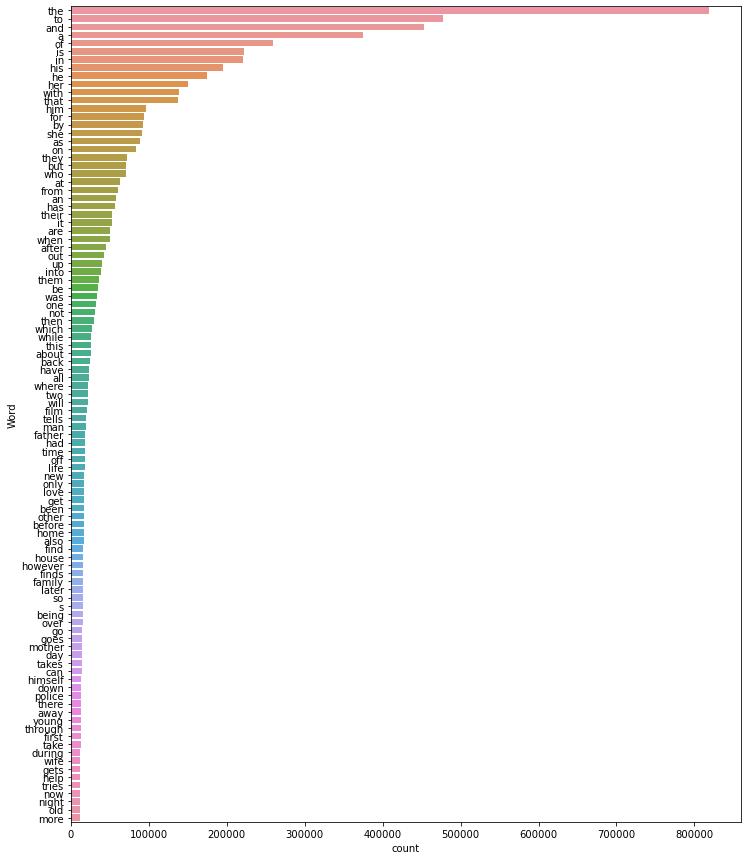

In [25]:
# print 100 most frequent words
freq_words(movies_new['clean_plot'], 100)

Most of the terms in the plot above are stopwords. Remove them from plots

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Removing the stopwords.

In [27]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

<ipython-input-27-850fe5bd6f01>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))


Check the most frequent words after the stopwords removal

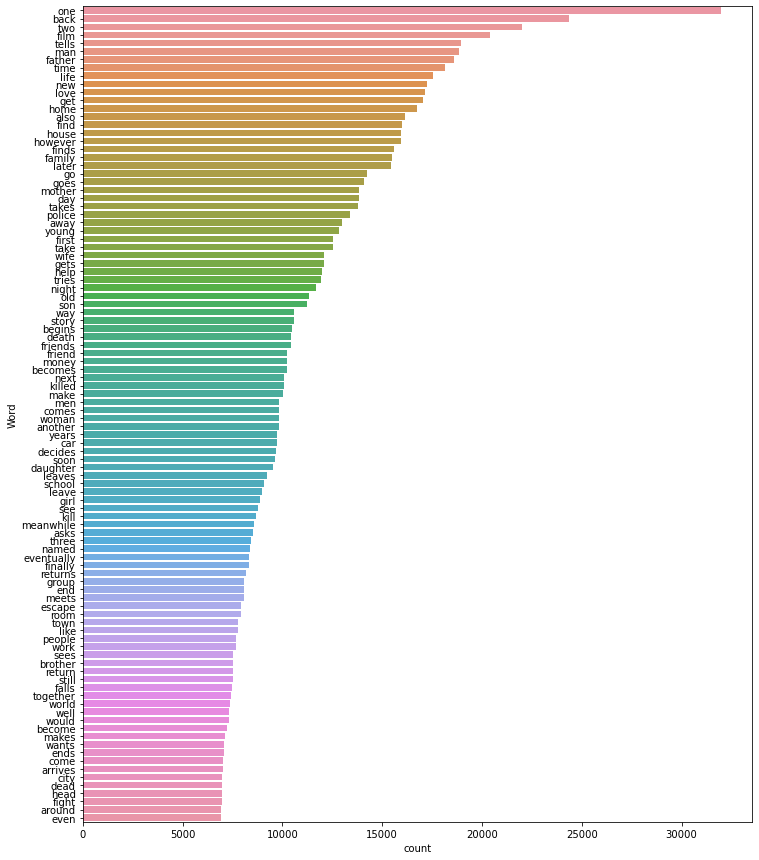

In [28]:
freq_words(movies_new['clean_plot'], 100)

### Converting Text to Features

**MultiLabelBinarizer( )**. Since there are 363 unique genre tags

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

max_df = 0.80 means "ignore terms that appear in more than 80% of the documents".

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# Original Code-Dont Run

In [31]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

# My Code

In [32]:
X_train, X_test, y_train, y_test = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.1, random_state=9)

Now we can create features for the train and the validation set.

# TFIDF Features

In [33]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [34]:
xtrain_tfidf[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 264 stored elements in Compressed Sparse Row format>

In [35]:
print(y_train[:10])

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Classifier for Movie Genre Prediction Model


In [36]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

We will use a Logistic Regression, which is a binary classification algorithm and use it with the One-vs-Rest heuristic to perform multi-class classification

In [37]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Finally we are going to fit our model on the train set

In [38]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

E:\Data Softwares\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
E:\Data Softwares\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
E:\Data Softwares\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
E:\Data Softwares\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 245 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
E:\Data Softwares\ANACONDA\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 281 is present in all training examples.
  warnings.warn("Label %s is present in all training examples.

OneVsRestClassifier(estimator=LogisticRegression())

In [39]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [40]:
y_pred[1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
multilabel_binarizer.inverse_transform(y_pred)[1000]

('Drama',)

In [42]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.31822930268999744

In [43]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [44]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [45]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.4411414366357657

In [46]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [47]:
for i in range(10):
    k = xval.sample(67).index[0]
    print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")   

Movie:  Mudhalvan 
Predicted genre:  [('Drama',)]
Actual genre:  ['Thriller', 'World cinema'] 

Movie:  Actor's and Sin 
Predicted genre:  [()]
Actual genre:  ['Comedy film', 'Drama'] 

Movie:  Daybreak 
Predicted genre:  [('Drama',)]
Actual genre:  ['Film noir'] 

Movie:  Annie: A Royal Adventure! 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Family Film', 'Comedy', 'Adventure', 'Television movie'] 

Movie:  Great Expectations 
Predicted genre:  [('Drama',)]
Actual genre:  ['Costume drama', 'Drama'] 

Movie:  Twenty Four Seven 
Predicted genre:  [()]
Actual genre:  ['Sports', 'Romance Film', 'Drama', 'Comedy', 'Boxing'] 

Movie:  Stonerville 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Sex comedy', 'Comedy', 'Indie'] 

Movie:  The Brotherhood III: Young Demons 
Predicted genre:  [()]
Actual genre:  ['Horror'] 

Movie:  Vrudhanmare Sookshikkuka 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Action', 'Comedy'] 

Movie:  Pop 'im Pop 
Predicted genre:  [('Animation', 'Famil

In [48]:
#GENSIM with Word2Vec

In [50]:
from gensim.models import Word2Vec

E:\Data Softwares\ANACONDA\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [81]:
model_ted = Word2Vec(sentences=movies_new['genre_new'], vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [82]:
movies_new

,movie_id,plot,movie_name,genre,genre_new,clean_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",shlykov hard working taxi driver lyosha saxoph...
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr...",nation panem consists wealthy capitol twelve p...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]",poovalli induchoodan sentenced six years priso...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]",lemon drop kid new york city swindler illegall...
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema...",seventh day adventist church pastor michael ch...
...,...,...,...,...,...,...
42199,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{""/m/0bj8m2"": ""Children's""}",[Children's],story reema young muslim schoolgirl malabar lo...
42200,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...","[Silent film, Indie, Black-and-white, Period p...",hollywood director leo andreyev looks photogra...
42201,35102018,American Luthier focuses on Randy ParsonsΓÇÖ t...,Randy Parsons: American Luthier,"{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music...","[Short Film, Music, Biographical film, Documen...",american luthier focuses randy parsons transfo...
42202,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{""/m/07s9rl0"": ""Drama""}",[Drama],abdur rehman khan middle aged dry fruit seller...


In [76]:
movies_new['genre_new'][0]

['Drama', 'World cinema']

In [86]:
model_ted.wv.most_similar(movies_new['genre_new'][1])

[('Glamorized Spy Film', 0.899092972278595),
 ('Spaghetti Western', 0.8869927525520325),
 ('Airplanes and airports', 0.8855802416801453),
 ('Future noir', 0.8526939153671265),
 ('Wuxia', 0.8476520776748657),
 ('Action Thrillers', 0.8474979400634766),
 ('Hybrid Western', 0.8451789021492004),
 ('Chase Movie', 0.8437111973762512),
 ('Master Criminal Films', 0.8335447311401367),
 ('Natural disaster', 0.8220720291137695)]

#Gensim With FastText

In [ ]:
import time
from gensim.models import FastText
start = time.time()
model_ted = FastText(sentences=movies_new['clean_plot'], vector_size=100, window=5, min_count=5, workers=4,sg=1)
end = time.time()
print('Time to train fasttext from generator: %0.2fs' % (end - start))

In [58]:
!pip install keras

In [59]:
!pip install --user tensorflow==2.2

In [60]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Softmax, Dropout

model = Sequential()
model.add(Dense(256, input_shape = xtrain_tfidf[0].shape, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'sigmoid'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(19))
model.add(Softmax())

In [61]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 256)            2560256   
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1, 19)             2

In [63]:
history = model.fit(xtrain_tfidf, ytrain, validation_data = (xval_tfidf, yval), epochs = 20)

InvalidArgumentError: indices[2] = [0,3286] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

NameError: name 'history' is not defined

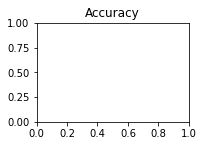

In [64]:
import matplotlib.pyplot as plt

plt.subplot(221)
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.subplot(222)
plt.title("Loss")
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.subplot(223)
plt.title("Accuracy")
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.subplot(224)
plt.title("Loss")
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()